In [1]:
from functions import *
from models import *

2024-11-29 13:16:24.357761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 13:16:24.378001: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 13:16:24.384214: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 13:16:24.400501: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-29 13:16:25.537397: W tensorflow/compiler/tf2

In [2]:
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import time
from datetime import datetime
from collections import Counter
from multiprocessing import Pool
import gc

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Load data

In [4]:
def load_all_data(
    source_folder='../data/external/shp/river_cells_oficial',
    source_path='../data/preprocessed/',
    data_paths=['lst', 'slope', 'discharge', 'ndvi', 'altitude'],
    filter_altitude=None,
    W=256,
    time_split=False,
):
    
    dir_paths = [os.path.join(source_path, p) for p in data_paths]
    
    all_dir_paths = {k: [] for k in data_paths}
    total_data = {}
    total_times = {}

    if not filter_altitude:
        rivers = [f.split('station_')[-1].split('.')[0] for f in os.listdir(source_folder) if os.path.join(source_folder, f).endswith('shp')]
    else:
        rivers = get_rivers_altitude(source_folder)
    
    # Cargar rutas de entrada
    for i, dir_p in enumerate(dir_paths):
        for subdir, dirs, files in os.walk(dir_p):
            if subdir != dir_p and not subdir.endswith('masked') and not subdir.endswith('.ipynb_checkpoints') and subdir.split('/')[-1] in rivers:
                all_dir_paths[data_paths[i]].append(subdir)
            elif dir_p.endswith('altitude'):
                all_dir_paths[data_paths[i]].extend([f for f in files if f.split('.')[0] in rivers])

    #print(all_dir_paths)
    # Cargar datos de entrada
    for k, v in all_dir_paths.items():
        if k not in ['direction', 'slope', 'altitude']:
            labels = []
            list_rgb = [True] * len(v) if k in ['lst', 'masked'] else [False] * len(v)
            data, times = load_data(v, W, list_rgb)
            if k != 'masked':
                for ki in data.keys():
                    labels += [ki.split('/')[-1]] * len(data[ki])

            data_values = [np.array(img) for sublist in list(data.values()) for img in sublist]
            times_list = [t for sublist in times for t in sublist]

            if time_split:
                dates = [datetime.strptime(date, '%Y-%m') for date in times_list]
                pairs = sorted(zip(dates, data_values, labels), key=lambda x: x[0])
                sorted_dates, data_values, labels = zip(*pairs)
                times_list = [date.strftime('%Y-%m') for date in sorted_dates]

            total_data[k] = np.array(data_values)
            total_times[k] = times_list
            print(f"{k} : {total_data[k].shape}")

    # Cargar variables adicionales
    for k, v in all_dir_paths.items():
        if k in ['direction', 'slope', 'altitude']:
            imgss = {}
            total = []
            for i, lab in enumerate(labels):
                for file in v:
                    if lab in file.split('/')[-1] or lab in file.split('.')[0]:
                        if lab not in imgss:
                            file_path = os.path.join(file, os.listdir(file)[0]) if k != 'altitude' else os.path.join(f'{source_path}altitude', file)
                            r, m = load_raster(file_path, False)
                            var = resize_image(r, W, W)
                            var = np.where(np.isnan(var), 0.0, var)
                            imgss[lab] = var
                        else:
                            var = imgss[lab]
                            
                total.append(var)

            total_data[k] = np.array(total)
            print(f"{k}: {np.array(total).shape}")

    # Cargar variable objetivo
    water_temp = pd.read_csv(f'{source_path}wt/water_temp.csv', index_col=0)
    times_ordered = total_times['lst']
    wt_temp = []
    for cell, date in zip(labels, times_ordered):
        temp = water_temp[(water_temp["Cell"] == cell) & (water_temp["Date"] == date)]["WaterTemp"]
        if not temp.empty:
            wt_temp.append(temp.values[0])
    data_targets = np.array(wt_temp)

    return total_data, total_times, data_targets, labels

In [5]:
W=64
split = 'random'
inputs = ['lst','ndvi']
source = '../data/preprocessed_test/'

if W==128:
    data_folder = source
else:
    data_folder = f'{source}64x64/'

data = load_all_data(
source_folder='../data/external/shp/river_cells_oficial',
source_path=data_folder,
data_paths= inputs,
filter_altitude=False,
W=W,
time_split=True if split=='time' else False)



lst : (1487, 64, 64, 3)
ndvi : (1487, 64, 64)


In [6]:
total_data, total_times, data_targets, labels = data

### Concatenate additional inputs

#### Vectorize dates

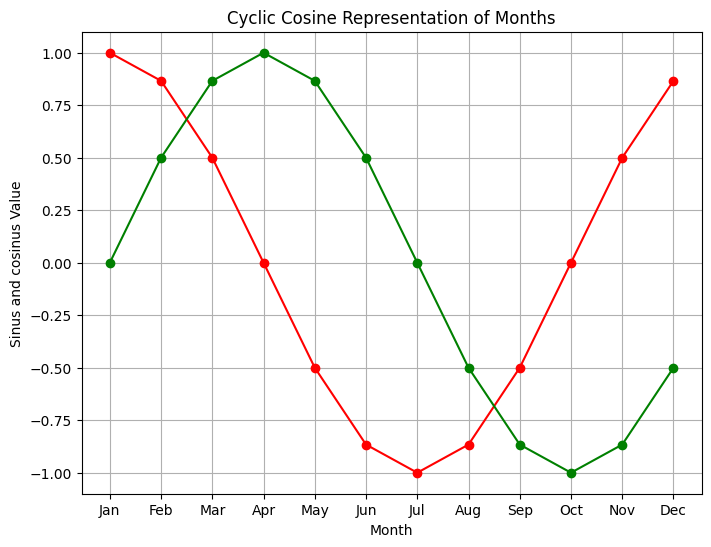

In [7]:
import numpy as np

def get_months_vectorized(times):
    """
    Calculate the cosine and sine values for each month in a given list of dates.
    Additionally, return a dictionary that maps each unique cosine value to its corresponding month.
    
    Parameters:
    ----------
    times : list or array-like
        A list of date strings or datetime objects from which month information is extracted.
        
    Returns:
    -------
    cosine_months : np.ndarray
        An array of cosine values corresponding to each month in the `times` input.
        
    sine_months : np.ndarray
        An array of sine values corresponding to each month in the `times` input.
        
    cos_to_month : dict
        A dictionary where each key is a unique cosine value and the corresponding value is the month (1-12) 
        associated with that cosine value."""
    
    month_cosine_dict = {month: np.cos((month - 1) / 12 * 2 * np.pi) for month in range(1, 13)}
    month_sinus_dict = {month: np.sin((month - 1) / 12 * 2 * np.pi) for month in range(1, 13)}
    
    cos_to_month = {cos_val: month for month, cos_val in month_cosine_dict.items()}
    
    def cosine_for_month(month):
        return month_cosine_dict[month]

    def sine_for_month(month):
        return month_sinus_dict[month]

    cosine_vectorized = np.vectorize(cosine_for_month)
    sine_vectorized = np.vectorize(sine_for_month)

    times_dt = pd.to_datetime(times)
    months = times_dt.month

    cosine_months = cosine_vectorized(months)
    sine_months = sine_vectorized(months)
    
    return cosine_months, sine_months, cos_to_month

month_cosine_dict = {month: np.cos((month - 1) / 12 * 2 * np.pi) for month in range(1, 13)}
month_sinus_dict = {month: np.sin((month - 1) / 12 * 2 * np.pi) for month in range(1, 13)}
    
months = list(month_cosine_dict.keys())
cosine_values = list(month_cosine_dict.values())
sinus_values = list(month_sinus_dict.values())
str_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(8, 6))
plt.plot(months, cosine_values, marker='o',color='red')
plt.plot(months, sinus_values, marker='o',color='green')
plt.xticks(months, str_months)
plt.xlabel('Month')
plt.ylabel('Sinus and cosinus Value')
plt.title('Cyclic Cosine Representation of Months')
plt.grid(True)
plt.show()


In [8]:
cosine_months, sine_months, cos_to_month = get_months_vectorized(total_times['lst'])
print(len(cosine_months),len(sine_months))

1487 1487


#### Vectorize lat and lon

In [9]:
file_path = '../data/raw/wt/cell_coordinates_oficial.csv'
lat_lon = pd.read_csv(file_path)
lat_lon

,Cell,Latitude,Longitude
0,1,2656959,1259353.0
1,2,2733557,1118162.0
2,3,2629128,1140919.0
3,4,2734998,1182035.0
4,5,2623616,1200426.0
...,...,...,...
75,77,2611732,1272316.0
76,78,2604814,1192679.0
77,79,2658557,1218252.0
78,80,2561671,1187319.0


In [10]:
len(labels)
lats=[]
lons=[]
for label in labels:
    num_cell = int(label.split('_')[-1])
    lat = lat_lon[lat_lon.Cell==num_cell].Latitude.values[0]
    lon = lat_lon[lat_lon.Cell==num_cell].Longitude.values[0]
    lats.append(lat)
    lons.append(lon)
lats = np.array(lats)
lons = np.array(lons)
print(len(lats),len(lons))

1487 1487


In [11]:
additional_inputs = np.column_stack((cosine_months, sine_months, lats, lons))

## Do experiment

### Parameters

In [12]:
W = 64
filter_river = None#[3,11,12]
inputs = ['lst','ndvi']#,'slope', 'discharge','ndvi']#,'discharge', 'slope','altitude']#['ndvi','discharge', 'slope']
conditioned = False
batch_size = 64
epochs = 300
model_name = "baseline_CNN" #img_wise_CNN, UNet, transfer_learning_VGG16, CNN, img_2_img
stratified = False
physics_guided = False

#### Adapt inputs shape

In [14]:
print(total_data['lst'].shape)
filtered_data = total_data['lst'][...,0]
print(filtered_data.shape)

(1487, 64, 64, 3)
(1487, 64, 64)


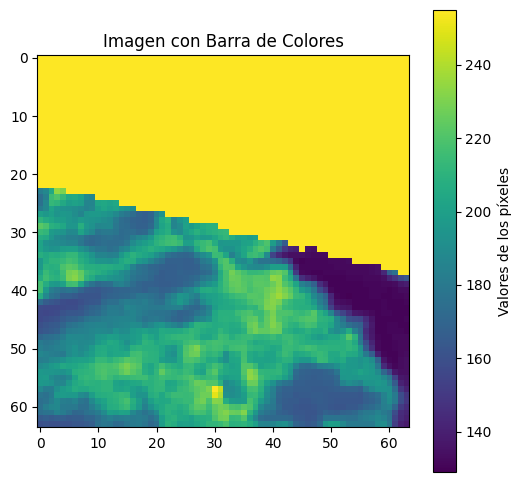

Valor mínimo: 129.0, Valor máximo: 255.0


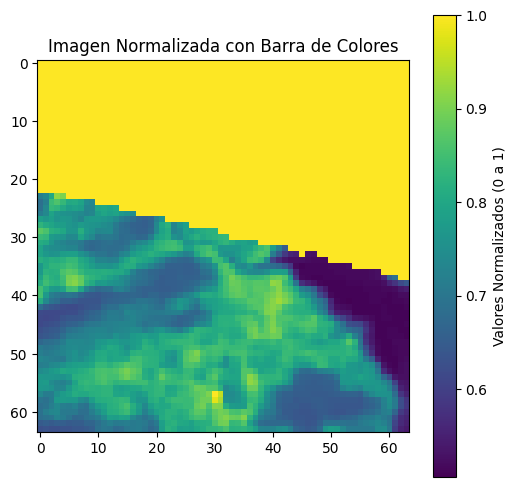

Valor mínimo (normalizado): 0.5058823529411764, Valor máximo (normalizado): 1.0


In [21]:
img = filtered_data[1046]  # Selecciona la imagen número 80

# Mostrar la imagen con una barra de color
plt.figure(figsize=(6, 6))
cax = plt.imshow(img, cmap="viridis")  # Cambia 'viridis' si prefieres otro colormap
plt.colorbar(cax, label="Valores de los píxeles")  # Añade una barra de color con etiqueta
plt.title("Imagen con Barra de Colores")
plt.show()

# Imprimir valores mínimo y máximo de la imagen
min_value = np.min(img)
max_value = np.max(img)
print(f"Valor mínimo: {min_value}, Valor máximo: {max_value}")

normalized_img = img / 255.0

# Mostrar la imagen normalizada con barra de colores
plt.figure(figsize=(6, 6))
cax = plt.imshow(normalized_img, cmap="viridis")  # Cambia 'viridis' si prefieres otro colormap
plt.colorbar(cax, label="Valores Normalizados (0 a 1)")  # Barra de color para explicar la escala
plt.title("Imagen Normalizada con Barra de Colores")
plt.show()

# Imprimir valores mínimo y máximo de la imagen normalizada
min_value = np.min(normalized_img)
max_value = np.max(normalized_img)
print(f"Valor mínimo (normalizado): {min_value}, Valor máximo (normalizado): {max_value}")

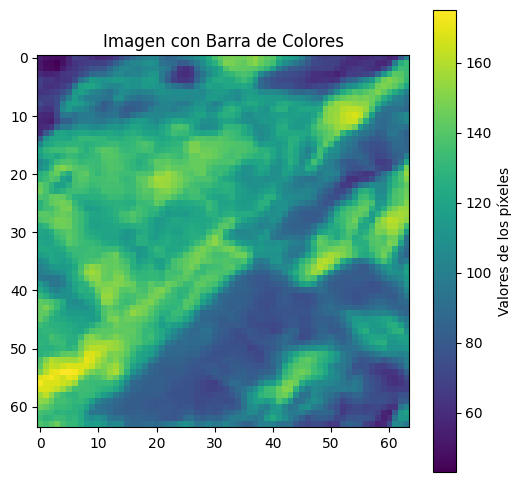

Valor mínimo: 43.0, Valor máximo: 175.0


In [18]:
img = filtered_data[80]  # Selecciona la imagen número 80

# Mostrar la imagen con una barra de color
plt.figure(figsize=(6, 6))
cax = plt.imshow(img, cmap="viridis")  # Cambia 'viridis' si prefieres otro colormap
plt.colorbar(cax, label="Valores de los píxeles")  # Añade una barra de color con etiqueta
plt.title("Imagen con Barra de Colores")
plt.show()

# Imprimir valores mínimo y máximo de la imagen
min_value = np.min(img)
max_value = np.max(img)
print(f"Valor mínimo: {min_value}, Valor máximo: {max_value}")


In [22]:
normalized_data = {}
for var, data in total_data.items():
    mean = np.mean(data)  # Mean of the variable
    std = np.std(data)    # Standard deviation of the variable

    # Avoid division by zero if std == 0
    if std == 0:
        print(f"Variable {var} has zero standard deviation.")
        normalized_data[var] = np.zeros_like(data)
    else:
        normalized_data[var] = (data - mean) / std

    # Print statistics for verification
    print(f"{var}: Mean after normalization = {np.mean(normalized_data[var]):.2f}, Std = {np.std(normalized_data[var]):.2f}")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
lst: Mean after normalization = 0.00, Std = 1.00
ndvi: Mean after normalization = 0.00, Std = 1.00


ValueError: x must have 2 or fewer dimensions

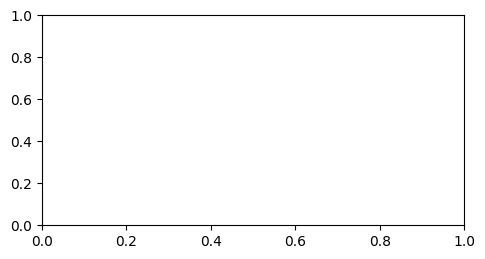

In [23]:
data_lst = total_data['lst'][...,0]
data_ndvi = total_data['ndvi']

# Normalize using z-score (mean and standard deviation)
mean_lst = np.mean(data_lst)
std_lst = np.std(data_lst)
normalized_lst = (data_lst - mean_lst) / std_lst

mean_ndvi = np.mean(data_ndvi)
std_ndvi = np.std(data_ndvi)
normalized_ndvi = (data_ndvi - mean_ndvi) / std_ndvi

# Plotting histograms
plt.figure(figsize=(12, 6))

# LST data
plt.subplot(2, 2, 1)
plt.hist(data_lst, bins=30, color='skyblue', edgecolor='black')
plt.title('LST Values Before Normalization')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(normalized_lst, bins=30, color='lightgreen', edgecolor='black')
plt.title('LST Values After Normalization (Z-Score)')
plt.xlabel('Normalized Value')
plt.ylabel('Frequency')

# NDVI data
plt.subplot(2, 2, 3)
plt.hist(data_ndvi, bins=30, color='salmon', edgecolor='black')
plt.title('NDVI Values Before Normalization')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(normalized_ndvi, bins=30, color='gold', edgecolor='black')
plt.title('NDVI Values After Normalization (Z-Score)')
plt.xlabel('Normalized Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [22]:
# Choose inputs
inputs_d = [total_data[inp] for inp in inputs]
# List to store the processed additional images
expanded_images = []
# Expand dimensions for single-channel images, leave multi-channel images as they are
for img in inputs_d:
    if img.ndim == 3:  # Case where image is (n, 256, 256) (single-channel)
        expanded_images.append(np.expand_dims(img, axis=-1))  # Expand to add an extra channel
    elif img.ndim == 4:  # Case where image already has multiple channels (n, 256, 256, c)
        expanded_images.append(img)  # Leave the image as it is
# Concatenate all images along the last axis (channels)
combined_input = np.concatenate(expanded_images, axis=-1)
# The final combined input is stored in input_data
input_data = combined_input

### Split data

In [24]:
if split=='time':
    train_ratio = 0.6
    val_ratio = 0.2
    test_ratio = 0.2
    
    # Calcular el tamaño de cada conjunto
    total_images = len(input_data)
    train_size = int(total_images * train_ratio)
    val_size = int(total_images * val_ratio)
    indices = np.arange(total_images)
    
    train_index = indices[:train_size]                       # Primeros índices para entrenamiento
    validation_index = indices[train_size:train_size + val_size]    # Siguientes índices para validación
    test_index = indices[train_size + val_size:]             # Últimos índices para prueba
       
elif stratified:
    train_index, validation_index, test_index = split_data_stratified(input_data, data_targets, labels)
else:
    train_index, validation_index, test_index = split_data(input_data, data_targets)
            
validation_input = input_data[validation_index, :] / 255.0  # Normalize inputs
validation_target = data_targets[validation_index]
test_input = input_data[test_index, :] / 255.0  # Normalize inputs
test_target = data_targets[test_index]
train_input = input_data[train_index, :] / 255.0  # Normalize inputs
train_target = data_targets[train_index]

additional_inputs_train = additional_inputs[train_index, :]
additional_inputs_validation = additional_inputs[validation_index, :]
additional_inputs_test = additional_inputs[test_index, :]

print(f"Train: {len(train_input)} imágenes, {train_input.shape}")
print(f"Val: {len(validation_input)} imágenes, {validation_input.shape}")
print(f"Test: {len(test_input)} imágenes, {test_input.shape}")
print(f" Additional inputs {additional_inputs.shape}")
print(train_target.shape, validation_target.shape, test_target.shape)

train_dates = np.array(total_times['lst'])[train_index] 
validation_dates = np.array(total_times['lst'])[validation_index] 
test_dates = np.array(total_times['lst'])[test_index] 

Train: 1191 imágenes, (1191, 64, 64, 4)
Val: 148 imágenes, (148, 64, 64, 4)
Test: 148 imágenes, (148, 64, 64, 4)
 Additional inputs (1487, 4)
(1191,) (148,) (148,)


In [25]:
print(train_dates)
print(validation_dates)
print(test_dates)

['2013-08' '2014-02' '2015-05' ... '2021-05' '2021-12' '2024-09']
['2019-07' '2019-04' '2021-09' '2023-09' '2018-07' '2013-08' '2023-06'
 '2021-01' '2017-01' '2018-03' '2019-01' '2015-03' '2021-12' '2013-07'
 '2019-02' '2024-01' '2024-08' '2023-09' '2018-03' '2014-10' '2021-09'
 '2022-08' '2016-10' '2015-01' '2020-11' '2022-05' '2020-07' '2020-11'
 '2018-08' '2013-05' '2015-08' '2017-08' '2015-02' '2023-07' '2024-08'
 '2016-01' '2017-05' '2013-04' '2017-01' '2017-05' '2014-09' '2021-09'
 '2019-06' '2022-08' '2014-04' '2014-09' '2015-08' '2022-09' '2020-02'
 '2019-04' '2021-06' '2019-09' '2018-04' '2014-01' '2014-06' '2024-09'
 '2022-03' '2022-10' '2018-10' '2019-10' '2016-10' '2022-07' '2024-09'
 '2016-04' '2019-11' '2017-12' '2015-11' '2024-01' '2017-08' '2014-07'
 '2016-06' '2018-11' '2020-10' '2020-10' '2016-08' '2014-05' '2017-04'
 '2024-09' '2014-12' '2017-08' '2013-11' '2019-11' '2019-03' '2015-09'
 '2019-02' '2017-12' '2020-11' '2016-01' '2014-11' '2015-12' '2018-07'
 '2016-02' 

#### Select inputs and model

In [26]:
if len(train_input.shape) == 3:
    input_shape = train_input.shape[1:]+(1,)
else:
    input_shape = train_input.shape[1:]
    
# Adapt input to condition
if conditioned:
    input_args = (input_shape, additional_inputs.shape[1])
    model_input = [train_input, additional_inputs_train]
    val_model_input = [validation_input, additional_inputs_validation]
    test_model_input = [test_input, additional_inputs_test]

else:
    input_args = input_shape
    model_input = train_input
    val_model_input = validation_input
    test_model_input = test_input

print(len(model_input))
    

1191


In [27]:
# Start model
start_time = time.time()
if model_name == "baseline_CNN":
    if conditioned:
        model = build_cnn_model_features(input_args[0], input_args[1])
    else:
        model = build_cnn_baseline2(input_args)
elif model_name == 'CNN':
    model = build_cnn_model(input_args)
elif model_name == 'img_2_img':
    model = build_img_2_img_model(input_args)
elif model_name == 'UNet':
    model = build_unet(input_args)
elif model_name == 'transfer_learning_VGG16':
    train_input = train_input[:, :, :, :3]
    model = build_transfer_model((W, W, 3))
elif model_name == "img_wise_CNN_improved":
    model = build_simplified_cnn_model_improved(input_args)
        

### Train model

In [28]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generates a Grad-CAM heatmap.
    Args:
        img_array: Input image array (batch of shape (1, height, width, channels)).
        model: The model to analyze.
        last_conv_layer_name: The name of the last convolutional layer.
        pred_index: Index of the target class for Grad-CAM.
    Returns:
        A heatmap of the Grad-CAM.
    """
    print('holaaaa',img_array.shape, last_conv_layer_name)
    
    model.trainable = True
    for layer in model.layers:
        print(f"{layer.name}: trainable = {layer.trainable}")

    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.outputs[0]]#.get_layer(last_deep_layer).output]
    )
    print(grad_model.summary())
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    # Record gradients
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        target_output = preds[:,0]
        #tape.watch(last_conv_layer_output)
       
    
    print("Target output:", target_output)
    print("Tape variables:", tape.watched_variables())
    
    # Compute the gradients
    grads = tape.gradient(target_output, last_conv_layer_output)
    #grads = tape.gradient(target_output, img_tensor)
    print(grads)
    # Compute the mean intensity of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by the pooled gradients
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [31]:
# Create batch dataset
dataset = tf.data.Dataset.from_tensor_slices((*model_input, train_target) if conditioned else (model_input, train_target))
dataset = dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
dataset_val = tf.data.Dataset.from_tensor_slices((*val_model_input, validation_target) if conditioned else (val_model_input, validation_target))
dataset_val = dataset_val.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

#optimizer = tf.keras.optimizers.SGD()
optimizer = tf.keras.optimizers.Adam()
errors_log = {"epoch": [], "month": [], "error": []}
loss_per_epoch = []
val_loss_per_epoch = []

last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break
 
# Train model
for epoch in range(epochs):
    epoch_loss = 0  
    num_batches = 0
    start_idx = 0
    for batch in dataset:
        if conditioned:
            model_input_batch = batch[:-1]  
            target_batch = batch[-1]        
        else:
            model_input_batch, target_batch = batch  # Desempaquetado directo para un solo dataset
        
        with tf.GradientTape() as tape:
            y_pred = model([*model_input_batch], training=True) if conditioned else model(model_input_batch, training=True)
            if physics_guided:
                lst_batch = model_input_batch[0][:, :, :, :3] if conditioned else model_input_batch[:, :, :, :3]
                loss = conservation_energy_loss(target_batch, y_pred, lst_batch, alpha=0.5, beta=0.5)
            else:
                loss = root_mean_squared_error(target_batch, y_pred) 
        
        # Calculate gradients and apply optimization
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        epoch_loss += loss.numpy()
        num_batches += 1
        
        # Log variables values and error
        y_true = tf.cast(target_batch, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        current_batch_size = y_true.shape[0]
        batch_cosine_values = additional_inputs_train[:, 0][start_idx:start_idx + current_batch_size]
    
        for cos, pred, true in zip(batch_cosine_values, y_pred, y_true):
            squared_error = tf.square(pred - true) 
            rmse_sample = tf.sqrt(squared_error)  # RMSE 
            rmse_value = rmse_sample.numpy()
            errors_log["epoch"].append(epoch + 1)
            errors_log["month"].append(cos_to_month[cos])
            errors_log["error"].append(rmse_value)
        start_idx += current_batch_size
            
    avg_epoch_loss = epoch_loss / num_batches
    loss_per_epoch.append(avg_epoch_loss)
    val_loss = 0
    val_batches = 0
    
    for val_batch in dataset_val:
        if conditioned:
            val_input_batch = batch[:-1]  
            val_target_batch = batch[-1]        
        else:
            val_input_batch, val_target_batch = batch
        
        if len(val_input_batch.shape) == 3:  # Add batch dimension if missing
            val_input_batch = tf.expand_dims(val_input_batch, axis=0)
        
        
        val_pred = model([*val_input_batch], training=False) if conditioned else model(val_input_batch, training=False)
        val_loss += root_mean_squared_error(val_target_batch, val_pred).numpy()
        val_batches += 1

        with tf.GradientTape() as tape_val:
            tape_val.watch(val_input_batch)  # Rastrear las entradas
            val_pred = model([*val_input_batch], training=False) if conditioned else model(val_input_batch, training=False)
            target_output = val_pred[:, 0]  # Salida escalar
        val_input_gradients = tape_val.gradient(target_output, val_input_batch)
        
        impact_channel = 3
        image_path = f"../plots/grad_cam/gradients_epoch_{epoch}_batch_{val_batches}_channel_{impact_channel}.png"
        print(val_input_gradients.shape)
        save_grad_map(val_input_gradients, image_path, impact_channel)
        
    avg_val_loss = val_loss / val_batches
    val_loss_per_epoch.append(avg_val_loss)

    print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_epoch_loss:.4f} - Val Loss: {avg_val_loss:.4f}")
    gc.collect()

print('Done training')

2024-11-18 15:40:11.293727: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 1/300 - Loss: 5.3211 - Val Loss: 6.2594
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 2/300 - Loss: 5.2978 - Val Loss: 6.0206
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 3/300 - Loss: 5.2139 - Val Loss: 5.7401
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 4/300 - Loss: 5.1433 - Val Loss: 5.2972


2024-11-18 15:40:32.400797: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 5/300 - Loss: 5.1454 - Val Loss: 5.0837
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 6/300 - Loss: 5.1624 - Val Loss: 4.8209
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 7/300 - Loss: 5.1508 - Val Loss: 4.1433
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 8/300 - Loss: 5.1626 - Val Loss: 3.6875
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 9/300 - Loss: 5.0901 - Val Loss: 3.4728
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 10/300 - Loss: 5.0288 - Val Loss: 3.4368
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 11/300 - Loss: 5.0442 - Val Loss: 3.2472
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 12/300 - Loss: 5.0365 - Val Loss: 3.2140


2024-11-18 15:41:14.090294: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 13/300 - Loss: 5.0335 - Val Loss: 3.2150
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 14/300 - Loss: 4.9866 - Val Loss: 3.2225
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 15/300 - Loss: 4.9763 - Val Loss: 3.2311
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 16/300 - Loss: 4.9503 - Val Loss: 3.3275
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 17/300 - Loss: 4.9509 - Val Loss: 3.2928
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 18/300 - Loss: 4.9308 - Val Loss: 3.2997
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 19/300 - Loss: 4.9182 - Val Loss: 3.2208
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 20/300 - Loss: 4.9273 - Val Loss: 3.3135
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 21/300 - Loss: 4.9384 - Val Loss: 3.2577
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 22/300 - Loss: 4.8999 - Val Loss: 3.1450
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Ep

2024-11-18 15:42:39.033807: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 29/300 - Loss: 4.8668 - Val Loss: 3.3414
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 30/300 - Loss: 4.8929 - Val Loss: 3.5245
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 31/300 - Loss: 4.8537 - Val Loss: 3.5013
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 32/300 - Loss: 4.8649 - Val Loss: 3.4935
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 33/300 - Loss: 4.8372 - Val Loss: 3.5334
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 34/300 - Loss: 4.8144 - Val Loss: 3.4411
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 35/300 - Loss: 4.8109 - Val Loss: 3.3126
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 36/300 - Loss: 4.8045 - Val Loss: 3.5908
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 37/300 - Loss: 4.7933 - Val Loss: 3.3637
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 38/300 - Loss: 4.7836 - Val Loss: 3.4034
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Ep

2024-11-18 15:45:34.275167: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 61/300 - Loss: 4.7283 - Val Loss: 3.5966
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 62/300 - Loss: 4.7209 - Val Loss: 3.3497
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 63/300 - Loss: 4.7196 - Val Loss: 3.3142
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 64/300 - Loss: 4.7039 - Val Loss: 3.4597
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 65/300 - Loss: 4.7317 - Val Loss: 3.4313
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 66/300 - Loss: 4.7386 - Val Loss: 3.6473
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 67/300 - Loss: 4.7327 - Val Loss: 3.2459
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 68/300 - Loss: 4.7551 - Val Loss: 3.4891
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 69/300 - Loss: 4.7214 - Val Loss: 3.2616
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 70/300 - Loss: 4.7188 - Val Loss: 3.3322
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Ep

2024-11-18 15:51:45.744793: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 125/300 - Loss: 4.6604 - Val Loss: 3.3474
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 126/300 - Loss: 4.6753 - Val Loss: 3.3216
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 127/300 - Loss: 4.6694 - Val Loss: 3.3028
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 128/300 - Loss: 4.6738 - Val Loss: 3.3242
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 129/300 - Loss: 4.6585 - Val Loss: 3.4676
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 130/300 - Loss: 4.6630 - Val Loss: 3.3320
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 131/300 - Loss: 4.6715 - Val Loss: 3.3890
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 132/300 - Loss: 4.6517 - Val Loss: 3.4671
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 133/300 - Loss: 4.6566 - Val Loss: 3.4187
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 134/300 - Loss: 4.6713 - Val Loss: 3.5431
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64,

2024-11-18 16:06:36.022795: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 253/300 - Loss: 4.6712 - Val Loss: 3.3853
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 254/300 - Loss: 4.6846 - Val Loss: 3.3950
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 255/300 - Loss: 4.6647 - Val Loss: 3.3507
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 256/300 - Loss: 4.6477 - Val Loss: 3.4069
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 257/300 - Loss: 4.6630 - Val Loss: 3.4015
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 258/300 - Loss: 4.6636 - Val Loss: 3.5351
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 259/300 - Loss: 4.6756 - Val Loss: 3.5370
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 260/300 - Loss: 4.6640 - Val Loss: 3.5789
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 261/300 - Loss: 4.6585 - Val Loss: 3.4412
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64, 64, 4)
Epoch 262/300 - Loss: 4.6493 - Val Loss: 3.4586
(39, 64, 64, 4)
(39, 64, 64, 4)
(39, 64,

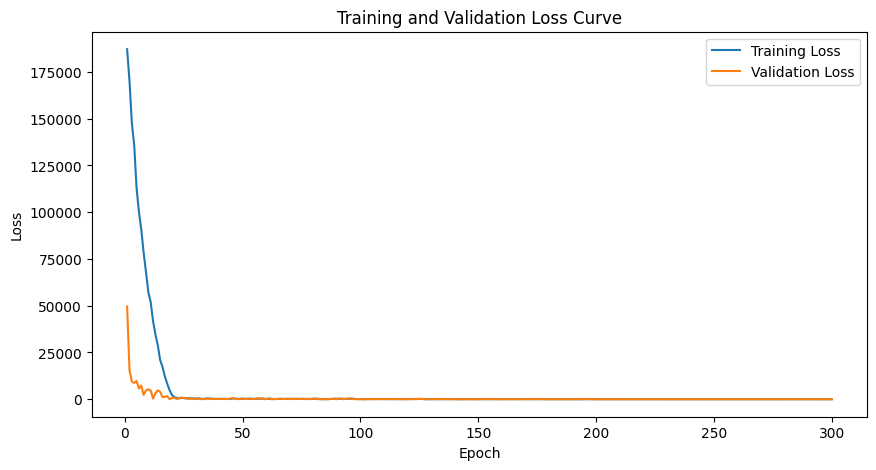

/home/ruth.parajo/miniconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Image_Input', 'Additional_Features_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(
I0000 00:00:1731579142.633219 4103175 service.cc:146] XLA service 0x7f4ab0004480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731579142.633275 4103175 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
I0000 00:00:1731579142.633297 4103175 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-11-14 11:12:22.649348: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  
7.587073361039386


I0000 00:00:1731579143.295020 4103175 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/home/ruth.parajo/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [38]:
# Convert the error log to a DataFrame for further analysis
errors_df = pd.DataFrame(errors_log)
errors_df["error"] = errors_df["error"].apply(lambda x: x[0] if len(x) == 1 else x)


plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss_per_epoch, label='Training Loss')
plt.plot(range(1, epochs + 1), val_loss_per_epoch, label='Validation Loss')
plt.title("Training and Validation Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluate results
test_prediction = model.predict(test_model_input)
rmse_test = mean_squared_error(test_target, test_prediction, squared=False)
print(rmse_test)

In [39]:
laabeel = 'month' if conditioned else 'no label'
var_inputs = '' if inputs == None else ', '.join(inputs)
variables = ', '.join([var_inputs, laabeel])

details = {'Experiment':[0],'RMSE':[rmse_test],'Variables':[variables],'Input': [f'{len(np.unique(labels))} rivers'], 'Split': ['random'], \
               'nº samples': [len(data_targets)], 'Batch size': [batch_size], 'Epochs': [epochs],  \
               'Loss':  ['Physics-guided' if physics_guided else 'RMSE']}
pd.DataFrame(details)

,Experiment,RMSE,Variables,Input,Split,nº samples,Batch size,Epochs,Loss
0,0,7.587073,"lst, month",47 rivers,random,968,64,300,RMSE


In [ ]:
import pandas as pd
model_name = 'baseline_CNN'
pd.read_excel(f'../results/{model_name}_results.xlsx')

## Visualize results

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
plt.figure(figsize=(16,5))
#plt.clf
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Simpler CNN MSE Loss during training --- lst+ndvi with wt target')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.savefig('../plots/cnn.png',dpi=100)

In [ ]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE during training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

#### Validate and test

Image wise metrics results

See what are the areas with more prediction error

In [ ]:
if len(validation_prediction.shape) == 4:
  validation_prediction=np.squeeze(validation_prediction, axis=3)

diff = validation_prediction - validation_target
for i in range(diff.shape[0]):
  sns.heatmap(diff[i], cmap='coolwarm')
  plt.title('Prediction Error Heatmap')
  plt.show()

Dispersion graph and histogram of prediction errors

In [ ]:
validation_target_flat = validation_target.reshape(-1)
validation_prediction_flat = validation_prediction.reshape(-1)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supongamos que y_true son tus valores reales y y_pred son tus predicciones
y_true = validation_target_flat # Valores reales
y_pred = validation_prediction_flat  # Predicciones del modelo

# Visualización
plt.scatter(y_true, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.title('True Values vs Predictions')
plt.show()

# Histograma de errores
errors = y_pred - y_true
plt.hist(errors, bins=30)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()
